### Day 1
### 星系的等照度线分析

* 作者: 朱帅儒（394，上海天文台）

* 更新于 2022-07-28

In [98]:
import numpy as np
import numpy.ma as ma
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model, EllipseSample
from photutils.isophote import Isophote, IsophoteList

In [59]:
def extract_fix_isophotes(image=None, xcen=None, ycen=None, initsma=None, eps=None, pa=None, step=None, 
                          linear_growth=False, minsma=None, maxsma=None, silent=False):
    """
    Function to extract surface brightness profile with fixed center, ellipticity, and position angle.
    """
    syntax = "syntax: results = extract_fix_isophotes(image=, xcen=, ycen=, initsma=, eps=, pa=, step=, linear_growth=False/True, minsma=None, maxsma=None, silent=False/True; minsma maxsma are optional)"
    if (None in [xcen, ycen, initsma, eps, pa, step]) or (image is None):
        print(syntax)
        return []
    print(syntax) if silent == False else print("")
    
    minsma = minsma if minsma is not None else 0.5
    maxsma = maxsma if maxsma is not None else max(np.shape(image))/2*1.3
    isophote_list = []

    geometry = EllipseGeometry(xcen, ycen, initsma, eps, pa, astep=step, linear_growth=False, 
                               fix_center=True, fix_pa=True, fix_eps=True)
    
    sma = initsma
    while True:
        sample = EllipseSample(image, sma, geometry=geometry)

        sample.update(geometry.fix)
        isophote = Isophote(sample, 0, True, stop_code=4)
        isophote_list.append(isophote)
        sma = isophote.sample.geometry.update_sma(step)
        if maxsma and sma >= maxsma:
            break

    first_isophote = isophote_list[0]
    sma, step = first_isophote.sample.geometry.reset_sma(step)

    while True:
        sample = EllipseSample(image, sma, geometry=geometry)

        sample.update(geometry.fix)
        isophote = Isophote(sample, 0, True, stop_code=4)
        isophote_list.append(isophote)
        sma = isophote.sample.geometry.update_sma(step)
        if minsma and sma <= max(minsma, 0.5):
            break

    isophote_list.sort()
    iso_fix = IsophoteList(isophote_list)
    
    return iso_fix

### 载入数据，这里使用了作者提供的Mask

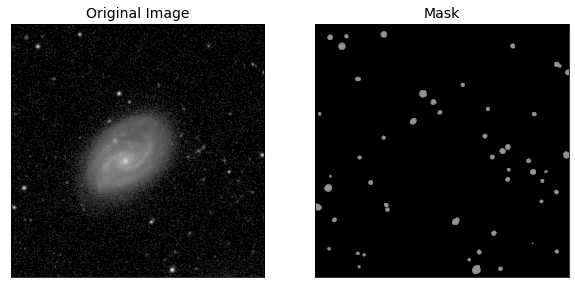

In [46]:
image = fits.getdata("data/UGC9476_i.fits")
im_mask = fits.getdata("data/UGC9476_i_mask.fits")

masked_image = np.ma.array(data=image, mask=im_mask)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5),
                        sharex=True, sharey=True)
norm = ImageNormalize(stretch=LogStretch(a=2000), vmin=0, vmax=50)

ax[0].imshow(image, cmap="Greys_r", norm=norm, origin="lower")
ax[1].imshow(mask, cmap="Greys_r", norm=norm, origin="lower")

ax[0].set_title("Original Image", fontsize=14)
ax[1].set_title("Mask", fontsize=14)
_ = ax[0].set_xticks([])
_ = ax[0].set_yticks([])


#### 第一次拟合
Photutils 的拟合程序是初始条件敏感的，**初始值需要大致在真值附近！**

In [47]:
# Initial Guess
run_params = {}

run_params['eps'] = 0.6
run_params['pa'] = 10       
run_params['sma'] = 100
run_params["x0"] = 252
run_params["y0"] = 255

geometry = EllipseGeometry(**run_params)
ellipse = Ellipse(masked_image, geometry)
iso_free = ellipse.fit_image(fix_center=False, fix_pa=False, fix_eps=False, 
    minsma=1, maxsma=250, step=0.15, maxgerr=1)

展示拟合结果：
利用一系列的椭圆去拟合星系的等照度线

* 分别是椭率、方位角、中心坐标（x, y)、表面亮度、以及面积比例这几个量半长轴的变化

* 可以从椭率和方位角的变化看到，这个星系是有悬臂的

* 利用较为靠里的几个等照度线拟合的结果先求出星系的中心

(0.0, 1.1)

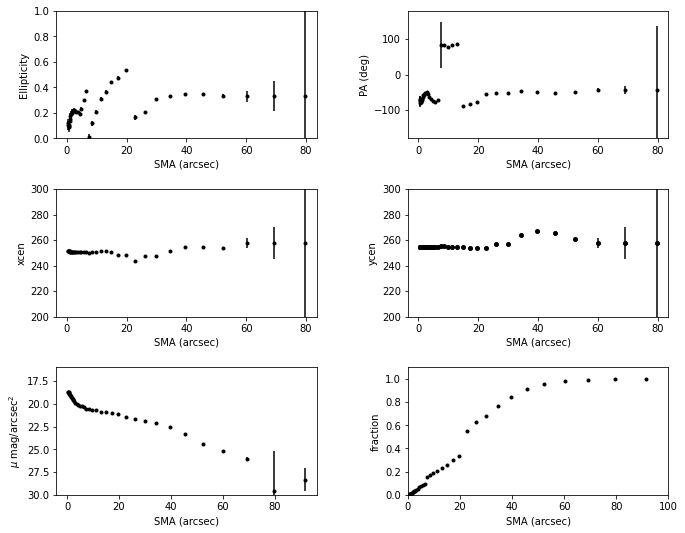

In [4]:
pixscl = 0.396 
ig = iso_free.stop_code != 4

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, 
                        right=0.95, hspace=0.4, wspace=0.35)

axes[0][0].errorbar(iso_free.sma[ig]*pixscl, iso_free.eps[ig], 
                        yerr=iso_free.ellip_err[ig], 
                        fmt='o', markersize=3, color='black')
axes[0][0].set_xlabel('SMA (arcsec)')
axes[0][0].set_ylabel('Ellipticity')
axes[0][0].set_ylim(0, 1)

axes[0][1].errorbar(iso_free.sma[ig]*pixscl, iso_free.pa[ig]/np.pi*180.-90, 
                        yerr=iso_free.pa_err[ig]/np.pi*180., 
                        fmt='o', markersize=3, color='black')
axes[0][1].set_xlabel('SMA (arcsec)')
axes[0][1].set_ylabel('PA (deg)')
axes[0][1].set_ylim(-180, 180)

axes[1][0].errorbar(iso_free.sma[ig]*pixscl, iso_free.x0[ig], 
                        yerr=iso_free.x0_err[ig], fmt='o', 
                        markersize=3, color='black')
axes[1][0].set_xlabel('SMA (arcsec)')
axes[1][0].set_ylabel('xcen')
axes[1][0].set_ylim(200, 300)

axes[1][1].errorbar(iso_free.sma[ig]*pixscl, iso_free.y0[ig], 
                        yerr=iso_free.y0_err[ig], fmt='o', 
                        markersize=4, color='black')
axes[1][1].set_xlabel('SMA (arcsec)')
axes[1][1].set_ylabel('ycen')
axes[1][1].set_ylim(200, 300)

mask = iso_free.intens > 0 
mu = -2.5*np.log10(iso_free.intens[mask]/pixscl**2) + 22.5
mu_err = 2.5*iso_free.int_err[mask]/iso_free.intens[mask]/np.log(10)

axes[2][0].errorbar(iso_free.sma[mask]*pixscl, mu, 
                yerr=mu_err, fmt='o', 
                markersize=3, color="black")
axes[2][0].set_ylim(30, 16)
axes[2][0].set_ylabel('$\mu$ mag/arcsec$^2$')
axes[2][0].set_xlabel('SMA (arcsec)')

axes[2][1].scatter(iso_free.sma*pixscl, iso_free.tflux_e/np.max(iso_free.tflux_e), 
                        color='black', marker='.')
axes[2][1].set_ylabel('fraction')
axes[2][1].set_xlabel('SMA (arcsec)')
axes[2][1].set_xlim(0, 100)
axes[2][1].set_ylim(0, 1.1)

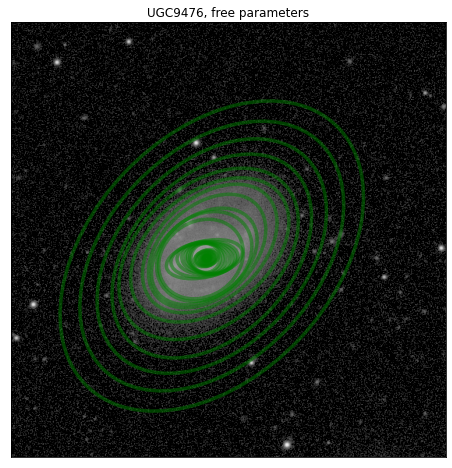

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))
norm = ImageNormalize(stretch=LogStretch(a=2000), vmin=0, vmax=50)

ax.imshow(image, origin='lower', cmap='Greys_r', norm=norm)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UGC9476, free parameters')

Niso = len(iso_free.sma)
for k in range(0, Niso):
    ellipse = patches.Ellipse((iso_free.x0[k], iso_free.y0[k]), 2*iso_free.sma[k], 
                      (1-iso_free.eps[k])*2*iso_free.sma[k], 
                      angle=iso_free.pa[k]*180/np.pi, alpha=0.5, fill=False, color='green',
                      linewidth=3.5)
    ax.add_artist(ellipse)

* 结果：
在像素坐标上：250.87, 254.73，转换到天球坐标系上的结果为220.38 deg, 44.51 deg

In [6]:
center_iso = iso_free.sma * pixscl < 10
wcs = WCS(fits.getheader("data/UGC9476_i.fits"))

x_fitted = np.mean(iso_free.x0[center_iso])
y_fitted = np.mean(iso_free.y0[center_iso])
center_pos = wcs.pixel_to_world(x_fitted, y_fitted)
ra, dec = center_pos.ra, center_pos.dec
print("[Pixel Coords] The center of the galaxies is {:.2f}, {:.2f}".format(x_fitted, y_fitted))
print("[WCS] The center of the galaxies is {:.2f}, {:.2f}".format(ra, dec))

[Pixel Coords] The center of the galaxies is 250.87, 254.73
[WCS] The center of the galaxies is 220.38 deg, 44.51 deg


#### 第二次拟合

* 将星系中心的信息固定好

In [63]:
# Update the params
run_params["x0"] = x_fitted
run_params["y0"] = y_fitted

geometry = EllipseGeometry(**run_params)
ellipse = Ellipse(masked_image, geometry)
iso_fixCen = ellipse.fit_image(fix_center=True, fix_pa=False, fix_eps=False, 
    minsma=1, maxsma=250, step=0.1, maxgerr=1)

#### 结果：
* PA，椭率，表面亮度，以及面积比随半长轴的变化
* 取外围的结果计算PA，椭率

(0.0, 1.1)

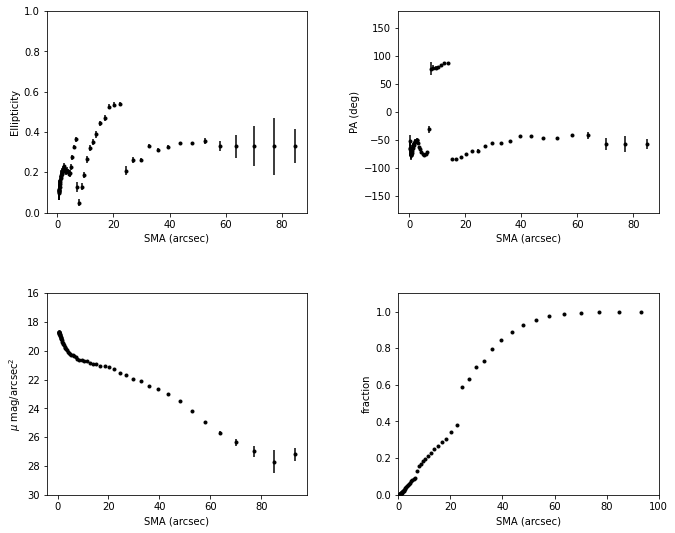

In [22]:
ig = iso_fixCen.stop_code != 4

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, 
                        right=0.95, hspace=0.4, wspace=0.35)

axes[0][0].errorbar(iso_fixCen.sma[ig]*pixscl, iso_fixCen.eps[ig], 
                        yerr=iso_fixCen.ellip_err[ig], 
                        fmt='o', markersize=3, color='black')
axes[0][0].set_xlabel('SMA (arcsec)')
axes[0][0].set_ylabel('Ellipticity')
axes[0][0].set_ylim(0, 1)

axes[0][1].errorbar(iso_fixCen.sma[ig]*pixscl, iso_fixCen.pa[ig]/np.pi*180.-90, 
                        yerr=iso_fixCen.pa_err[ig]/np.pi*180., 
                        fmt='o', markersize=3, color='black')
axes[0][1].set_xlabel('SMA (arcsec)')
axes[0][1].set_ylabel('PA (deg)')
axes[0][1].set_ylim(-180, 180)

mask = iso_fixCen.intens > 0 
mu = -2.5*np.log10(iso_fixCen.intens[mask]/pixscl**2) + 22.5
mu_err = 2.5*iso_fixCen.int_err[mask]/iso_fixCen.intens[mask]/np.log(10)

axes[1][0].errorbar(iso_fixCen.sma[mask]*pixscl, mu, 
              yerr=mu_err, fmt='o', 
              markersize=3, color="black")

axes[1][0].set_ylim(30, 16)
axes[1][0].set_ylabel('$\mu$ mag/arcsec$^2$')
axes[1][0].set_xlabel('SMA (arcsec)')

axes[1][1].scatter(iso_fixCen.sma*pixscl, iso_fixCen.tflux_e/np.max(iso_fixCen.tflux_e), 
                      color='black', marker='.')
axes[1][1].set_ylabel('fraction')
axes[1][1].set_xlabel('SMA (arcsec)')
axes[1][1].set_xlim(0, 100)
axes[1][1].set_ylim(0, 1.1)

In [67]:
outsk_mask = (iso_fixCen.stop_code == 0) & (iso_fixCen.sma * pixscl > 50)

eps_fitted = np.mean(iso_fixCen.eps[outsk_mask])
pa_fitted = np.mean(iso_fixCen.pa[outsk_mask])/np.pi*180. - 90
incl = np.arccos(1-eps_fitted)*180/np.pi
if pa_fitted < 0: # PA默认在0-180之间。
    pa_fitted += 180

eps_err = np.std(iso_fixCen.eps[outsk_mask])
pa_err = np.std(iso_fixCen.pa[outsk_mask]) /np.pi*180.
incl_err = 1/np.sqrt(1-(1-eps_fitted)**2)*eps_err*180/np.pi

run_params["pa"] = pa_fitted
run_params["eps"] = eps_fitted

print("[Pixel Coords] The center of the galaxies is {:.2f}, {:.2f}".format(eps_fitted, pa_fitted))

[Pixel Coords] The center of the galaxies is 0.34, 131.43


#### 第二次拟合得到的等照度线图

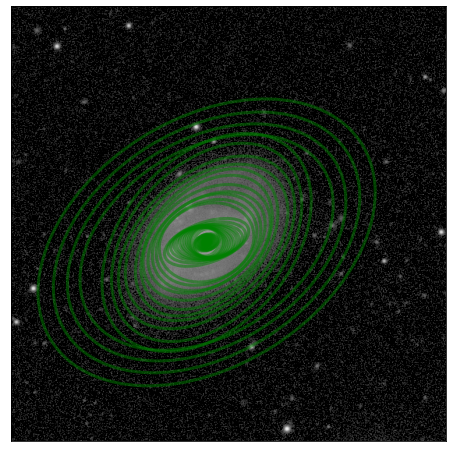

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
norm = ImageNormalize(stretch=LogStretch(a=2000), vmin=0, vmax=50)

ax.imshow(image, origin='lower', cmap='Greys_r', norm=norm)
ax.set_xticks([])
ax.set_yticks([])

Niso = len(iso_fixCen.sma)
for k in range(0, Niso):
    ellipse = patches.Ellipse((iso_fixCen.x0[k], iso_fixCen.y0[k]), 2*iso_fixCen.sma[k], 
                      (1-iso_fixCen.eps[k])*2*iso_fixCen.sma[k], 
                      angle=iso_fixCen.pa[k]*180/np.pi, alpha=0.5, fill=False, color='green',
                      lw=3)
    ax.add_artist(ellipse)

##### 利用第二次拟合的结果，建立星系的model,主要是求masked像素值

In [49]:
model_image = build_ellipse_model(image.shape, iso_fixCen)
kk = im_mask == 1
img_clean = np.copy(image)
img_clean[kk] = model_image[kk]

fits.writeto('model_image_UGC9476.fits', model_image, overwrite=True)
fits.writeto('clean_image_UGC9476.fits', img_clean, overwrite=True)

Text(0.5, 1.0, 'UGC 9476; cleaned i band image')

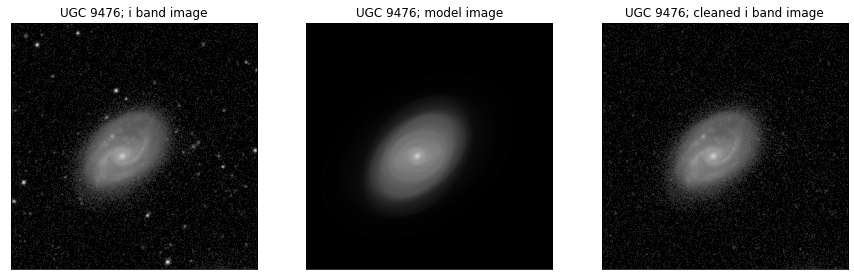

In [56]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

norm = ImageNormalize(stretch=LogStretch(a=2000), vmin=0, vmax=50)
axes[0].imshow(image, origin='lower', cmap='Greys_r', norm=norm)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('UGC 9476; i band image')

axes[1].imshow(model_image, origin='lower', cmap='Greys_r', norm=norm)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('UGC 9476; model image')

axes[2].imshow(img_clean, origin='lower', cmap='Greys_r', norm=norm)
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title('UGC 9476; cleaned i band image')

#### 提取等照度线

In [71]:
all_fix = extract_fix_isophotes(image=img_clean, xcen=run_params['x0'], ycen=run_params['y0'], 
                               initsma=20, eps=run_params['eps'], pa=(run_params['pa']+90)*np.pi/180, 
                                step=0.1) # 注意PA！！

syntax: results = extract_fix_isophotes(image=, xcen=, ycen=, initsma=, eps=, pa=, step=, linear_growth=False/True, minsma=None, maxsma=None, silent=False/True; minsma maxsma are optional)


#### 结果
* 等照度线的展示
* 面亮度以及面积比随半长轴的大小
* 亮度，以及形态学面积

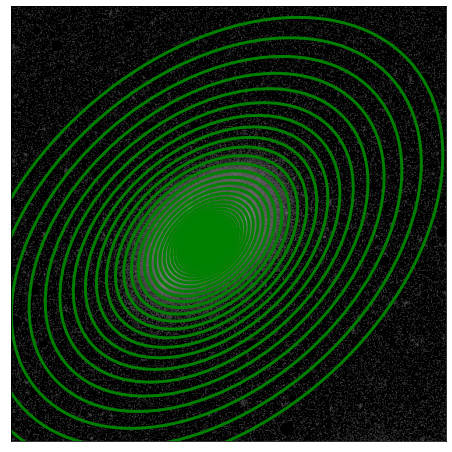

In [79]:
fig, ax = plt.subplots(figsize=(8, 8))

norm = ImageNormalize(stretch=LogStretch(a=2000), vmin=0, vmax=50)
ax.imshow(img_clean, origin='lower', cmap='Greys_r', norm=norm)
ax.set_xticks([])
ax.set_yticks([])

Niso = len(all_fix.sma)
for k in range(0, Niso):
    ellipse = patches.Ellipse((all_fix.x0[k], all_fix.y0[k]), 2*all_fix.sma[k], 
                      (1-all_fix.eps[k])*2*all_fix.sma[k], 
                      angle=all_fix.pa[k]*180/np.pi, alpha=1, fill=False, color='green',
                      lw=3)
    ax.add_artist(ellipse)

(0.0, 1.1)

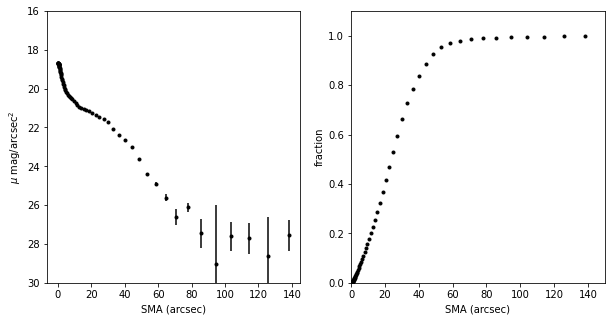

In [89]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
kk =  all_fix.intens > 0
mu = -2.5*np.log10( all_fix.intens[kk]/pixscl**2) + 22.5 # surface brightness profile
mu_err = 2.5* all_fix.int_err[kk]/ all_fix.intens[kk]/np.log(10)
sma_mu = all_fix.sma[kk] * pixscl

axes[0].errorbar(sma_mu, mu, yerr=mu_err, color='black', fmt='o', markersize=3)
axes[0].set_ylim(30, 16)
axes[0].set_ylabel('$\mu$ mag/arcsec$^2$')
axes[0].set_xlabel('SMA (arcsec)')

cog = all_fix.tflux_e/np.max( all_fix.tflux_e) # curve of growth，经常用来计算星系的size。
sma_cog = all_fix.sma * pixscl

axes[1].scatter(sma_cog, cog , color='black', marker='.')
axes[1].set_ylabel('fraction')
axes[1].set_xlabel('SMA (arcsec)')
axes[1].set_xlim(0, 150)
axes[1].set_ylim(0, 1.1)

In [96]:
# Apparent Magnitudes
flux_tot = np.sum(img_clean)
mag = -2.5*np.log10(flux_tot) + 22.5 
print('apparent magnitude:', mag.round(2), 'AB mag')
# Absolute Magnitudes
dist_mod = 30.03
Mag = mag - dist_mod
print('Absolute magnitude:', Mag.round(2), 'AB mag')
# R25, defined as R (mag = 25 mag) 
R25 = np.interp(25, mu, sma_mu)
print('projected major axis of a galaxy at the isophotal level 25 mag/arcsec2: ', 
            R25.round(1), 'arcsec')
# 50% flux radius, 20% flux radius, 80% flux radius
r50 = np.interp(0.5, cog, sma_cog) 
print('Half light radius: ', r50.round(1), 'arcsec')
r20 = np.interp(0.2, cog, sma_cog)
r80 = np.interp(0.8, cog, sma_cog)
Cindex = 5 * np.log10(r80/r20)
print('concentration index (reflect bulge prominence)', Cindex.round(2))

run_params.update({'mag':mag.round(2), 'Mag':Mag.round(2), 'R25':R25.round(1), 'r50':r50.round(1), 
               'C':Cindex.round(2)})

apparent magnitude: 12.45 AB mag
Absolute magnitude: -17.58 AB mag
projected major axis of a galaxy at the isophotal level 25 mag/arcsec2:  59.4 arcsec
Half light radius:  23.7 arcsec
concentration index (reflect bulge prominence) 2.55
